<a href="https://colab.research.google.com/github/Befezdow/ai_test/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

drive.mount('/content/gdrive')
names_array = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(60000)]]
url = '/content/gdrive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Подготавливаем данные, заполняя пропущенные значения медианой.

In [2]:
data = data.fillna(data.median(axis = 0), axis = 0)
data

,gender,age,class1,class2,class3,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,...,t59961,t59962,t59963,t59964,t59965,t59966,t59967,t59968,t59969,t59970,t59971,t59972,t59973,t59974,t59975,t59976,t59977,t59978,t59979,t59980,t59981,t59982,t59983,t59984,t59985,t59986,t59987,t59988,t59989,t59990,t59991,t59992,t59993,t59994,t59995,t59996,t59997,t59998,t59999,t60000
0,Female,85,3,5.0,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,5.0,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,5.0,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,5.0,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,5.0,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.645005,-0.816434,-0.952654,-1.038151,-1.073172,-1.060904,-1.006902,-0.914312,-0.803500,-0.697

Осуществляем аугментацию данных. На каждый датчик идет по 5000 записей. Разбиваем так, чтобы на каждый приходилось по 100, тем самым размножая данные.

In [0]:
current_count_per_sensor = 5000
needed_count_per_sensor = 100
sensors_count = 12

non_sliceable_columns = data.iloc[:,0:5]
sliceable_columns = data.iloc[:,5:]

current_offset = 0
new_data = pd.DataFrame()
for i in range(int(np.floor(current_count_per_sensor / needed_count_per_sensor))):
  new_offset = current_offset + needed_count_per_sensor
  new_slice = pd.DataFrame()
  
  for j in range(sensors_count):
    index_from = j * current_count_per_sensor + current_offset
    index_to = j * current_count_per_sensor + new_offset
    data_slice = sliceable_columns.iloc[:, index_from:index_to]
    new_slice = pd.concat([new_slice, data_slice], axis=1, sort=False, ignore_index=True)
  
  completed_rows = pd.concat([non_sliceable_columns.copy(), new_slice], axis=1, sort=False, ignore_index=True)
  new_data = pd.concat([new_data, completed_rows], axis=0, sort=False, ignore_index=True)
  current_offset += needed_count_per_sensor

new_data.columns = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(needed_count_per_sensor * sensors_count)]]

In [0]:
data = new_data

Выкидываем лишние классовые признаки, а затем осуществляем векторизацию и нормализацию данных.

In [5]:
# убираем лишние классовые признаки
data = data.drop('class2', axis = 1)
data = data.drop('class3', axis = 1)

#собираем числовые колонки
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object' and c != 'class1']

# векторизируем колонку gender
data.at[data['gender'] == 'Male', 'gender'] = 0
data.at[data['gender'] == 'Female', 'gender'] = 1

# нормализуем числовые атрибуты
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data[numerical_columns] = data_numerical

data

,gender,age,class1,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,...,t1161,t1162,t1163,t1164,t1165,t1166,t1167,t1168,t1169,t1170,t1171,t1172,t1173,t1174,t1175,t1176,t1177,t1178,t1179,t1180,t1181,t1182,t1183,t1184,t1185,t1186,t1187,t1188,t1189,t1190,t1191,t1192,t1193,t1194,t1195,t1196,t1197,t1198,t1199,t1200
0,1,1.177851,3,0.024810,0.089641,0.166249,0.079260,-0.183195,-0.239878,-0.229224,-0.311345,-0.353593,-0.276569,-0.194899,-0.124608,-0.107193,-0.176887,-0.201853,-0.266702,-0.334036,-0.375456,-0.389888,-0.385213,-0.248611,-0.170733,-0.265279,-0.231965,-0.162420,-0.280354,-0.328905,-0.320951,-0.306322,-0.279457,-0.310764,-0.396990,-0.447620,-0.450523,-0.453223,-0.495634,-0.503300,...,-0.281762,-0.281652,-0.282679,-0.280107,-0.265826,-0.244599,-0.226658,-0.234529,-0.236443,-0.258389,-0.269397,-0.244040,-0.233612,-0.233914,-0.240705,-0.260236,-0.264701,-0.214605,-0.232482,-0.247209,-0.285343,-0.309315,-0.304806,-0.269721,-0.277915,-0.276932,-0.274276,-0.224491,-0.258844,-0.260899,-0.258333,-0.254184,-0.247342,-0.230120,-0.231861,-0.225600,-0.247128,-0.245634,-0.256841,-0.266626
1,0,0.808696,9,0.089633,0.125414,0.117306,0.152087,0.150359,0.150870,0.149757,0.150433,0.151931,0.153868,0.192854,0.190815,0.116619,0.096582,0.095752,0.060556,0.039466,0.055681,0.060328,0.059317,0.059936,0.057892,0.059589,0.041363,-0.000022,-0.017737,-0.015379,-0.053639,-0.067829,-0.089579,-0.141626,-0.140784,-0.145060,-0.141832,-0.150440,-0.158980,-0.179465,...,1.277399,1.591452,1.949256,2.391251,2.901596,3.449840,3.954929,4.400384,4.779853,5.034665,5.030888,4.715864,4.194606,3.611433,3.115175,2.691228,2.311560,1.656903,1.643013,1.397020,1.215765,1.104194,1.042477,0.905557,0.931156,0.852095,0.756517,0.564518,0.604893,0.561188,0.533448,0.526664,0.530455,0.548706,0.558310,0.489712,0.516571,0.494300,0.479337,0.461718
2,0,0.008860,3,-0.068971,-0.061504,-0.069057,-0.062645,-0.056737,-0.049656,-0.049243,-0.048640,-0.040985,-0.048046,-0.040027,-0.032355,-0.025167,-0.032945,-0.032398,-0.032047,-0.039668,-0.032895,-0.025633,-0.032362,-0.025760,-0.019588,-0.006100,-0.014220,-0.008364,-0.008024,-0.013914,-0.014101,-0.014534,-0.007926,-0.001476,0.011986,0.032624,0.038989,0.046299,0.054910,0.056669,...,0.342476,0.363231,0.381090,0.392754,0.404233,0.416104,0.424317,0.434898,0.445092,0.451531,0.457970,0.458525,0.455772,0.455779,0.452729,0.447419,0.445639,0.374290,0.443081,0.440583,0.437367,0.431717,0.425354,0.380314,0.403103,0.394827,0.386485,0.321049,0.376301,0.371144,0.362767,0.356300,0.351041,0.339018,0.326720,0.289190,0.305516,0.292793,0.279864,0.265344
3,0,1.670058,2,-0.015739,0.031386,-0.014660,-0.043449,-0.036202,-0.061322,-0.144660,-0.262930,-0.273593,-0.184770,-0.168607,-0.259108,-0.315176,-0.221083,-0.163240,-0.075470,0.034093,0.143924,0.210039,0.123139,0.032848,0.017904,0.098192,0.109136,0.009856,-0.022685,-0.002609,-0.001402,0.079040,0.157510,0.198223,0.206091,0.210890,0.244174,0.359667,0.420744,0.257516,...,-0.082333,-0.057747,-0.029369,-0.023311,-0.013463,-0.002650,-0.002732,-0.000867,-0.001111,-0.000607,-0.000472,-0.000599,0.000362,-0.000267,0.006970,0.010258,0.009969,-0.007767,-0.012269,-0.002452,-0.011535,-0.012707,-0.014890,-0.022144,-0.022074,-0.023712,-0.016937,-0.016193,-0.039933,-0.058460,-0.060961,-0.055542,-0.052412,-0.052737,-0.033069,-0.017898,-0.034528,-0.032431,-0.049405,-0.045061
4,0,-0.052666,2,-0.224116,-0.200036,-0.101375,-0.173736,-0.180879,-0.263988,-0.253109,-0.100358,-0.070424,-0.163826,-0.240091,-0.236738,-0.131612,-0.125774,-0.220814,-0.235917,-0.073979,0.036815,0.046850,-0.017050,-0.040342,-0.039913,-0.061496,0.012219,0.049496,0.014800,-0.000405,-0.058276,-0.124513,-0.074536,-0.007725,-0.091796,-0.062091,-0.024787,-0.044343,0.028531,-0.055587,...,-0.049339,-0.049629,-0.048969,-0.048647,-0.047396,-0.047525,-0.037144,-0.019713,-0.018608,-0.016827,-0.002320,-0.006999,-0.009981,-0.007894,-0.010623,-0.022330,-0.025839,-0.029534,-0.030805,-0.02

Разбиваем данные на входы и выходы.

In [0]:
# бьем данные на входы и выходы
x = data.drop('class1', axis = 1)
y = data['class1']

Разбиваем данные на обучающую и тестовую выборки.

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 43750
Test dataset size: 18750


In [33]:
from sklearn import ensemble

estimators_number_list = list(np.arange(10, 111, 10))
train_error_list = []
test_error_list = []
oob_error_list = []
for estimators_number in estimators_number_list:
  rf_model = ensemble.RandomForestClassifier(n_estimators=estimators_number, oob_score = True)
  rf_model.fit(x_train, y_train)

  train_error = np.mean(rf_model.predict(x_train) != y_train)
  test_error  = np.mean(rf_model.predict(x_test) != y_test)
  oob_error = 1 - rf_model.oob_score_

  train_error_list.append(train_error)
  test_error_list.append(test_error)
  oob_error_list.append(oob_error)

  print(train_error, test_error, oob_error)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.018377142857142856 0.5249066666666666 0.6013257142857142


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.011657142857142857 0.4926933333333333 0.5556114285714286
0.01104 0.4774933333333333 0.5229257142857142
0.010971428571428571 0.46288 0.5031314285714286
0.010925714285714285 0.45738666666666666 0.4930285714285715
0.010925714285714285 0.4512 0.4823085714285714
0.010925714285714285 0.44976 0.47771428571428576
0.010925714285714285 0.44672 0.4696228571428571
0.010925714285714285 0.4448533333333333 0.46827428571428575
0.010925714285714285 0.44261333333333336 0.4636571428571429
0.010925714285714285 0.44 0.45881142857142854


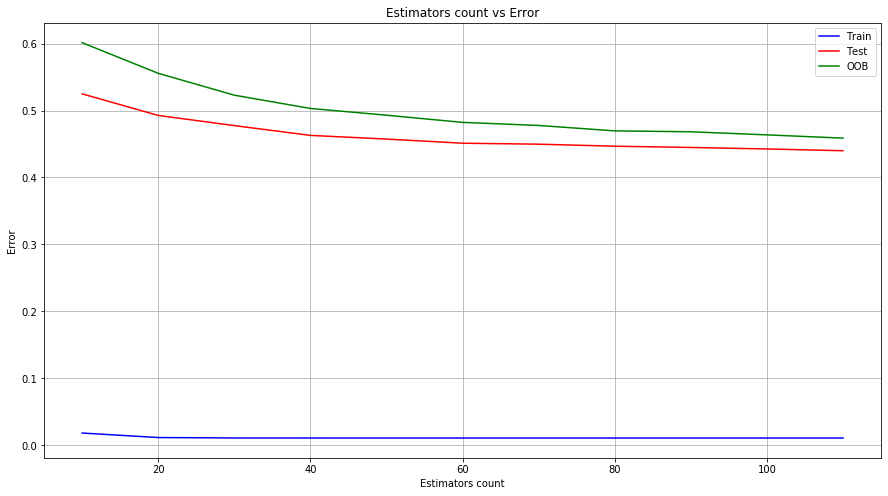

In [35]:
plt.figure(figsize = (15, 8))
plt.plot(estimators_number_list, train_error_list, label = 'Train', color = 'blue')
plt.plot(estimators_number_list, test_error_list, label = 'Test', color = 'red')
plt.plot(estimators_number_list, oob_error_list, label = 'OOB', color = 'green')

plt.xlabel('Estimators count')
plt.ylabel('Error')
plt.title('Estimators count vs Error')
plt.legend()
plt.grid()

In [28]:
number_of_estimators = 10
gbt_model = ensemble.GradientBoostingClassifier(n_estimators = number_of_estimators, subsample=0.5)
gbt_model.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [32]:
err_train = np.mean(y_train != gbt_model.predict(x_train))
err_test = np.mean(y_test != gbt_model.predict(x_test))

x = np.arange(number_of_estimators) + 1
cumsum = -np.cumsum(gbt_model.oob_improvement_)
oob_best_iter = x[np.argmin(cumsum)]

print(err_train, err_test, oob_best_iter)

0.57248 0.5857066666666667 10
